# Credit Default Prediction (Credit Card Default Dataset)
- Difficulty: Intermediate
- Project Purpose: Predict client default/no-default; stretch → apply class weights, evaluate ROC–AUC.
- Points Examined: LogisticRegression, class imbalance handling, probability outputs.
- Doc References: Logistic regression (penalties/solvers), Class imbalance.
- Why Useful: Teaches handling imbalanced datasets + probability calibration.

# Part 0 Dataset download

In [1]:
from numpy.distutils.conv_template import header
from sklearn.pipeline import make_pipeline
!curl -L -o ./default-of-credit-card-clients-dataset.zip https://www.kaggle.com/api/v1/datasets/download/uciml/default-of-credit-card-clients-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1001k  100 1001k    0     0   504k      0  0:00:01  0:00:01 --:--:-- 1291k


In [2]:
! ls

credit_default_prediction.ipynb
default-of-credit-card-clients-dataset.zip


In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
data = pd.read_csv('./default-of-credit-card-clients-dataset.zip')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Part 1 Hypothesis and project plan
The idea is to make a report on top of the dataset, or say a report helper, that can:
- Give a basic prediction on whether a people will default or not
- Give a ROC - AUC curve so can suggest if the bank want to be more aggressive or preventative, and what are the cost of moving to each direction
- Start with L2 and see if L1, elastic net can help, based on the data size, maybe will also do learning curve if datasize is small to avoid lucky split
- See if modifying weights for log regression have any effect for precision and recall

# Part 2 Pre-processing

In [8]:
# Scaler will be put into the pipeline to avoid data leakage
data.isnull().sum() # missing value seems pretty solid

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [15]:
print(data.shape) # That's many data, will check for how many of them are positive if there's much, then we might not border doing learning_curve as large enough sample is less likely to have lucky split
print(data.groupby('default.payment.next.month').size()) # humm this is not that bad, will not do re-sampling in this case, but will pay special attention to recall rate, as it is expected that FN would be large as it might tend to negative cases, will print learning curve for recall later

(30000, 25)
default.payment.next.month
0    23364
1     6636
dtype: int64


In [95]:
# Since there are no missing values, and all values are pre-processed into numeric number, will come to next part of training
from sklearn.model_selection import train_test_split
X = data.iloc[:, 1: -1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Part 3 Baseline Model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
baseline = make_pipeline(
    StandardScaler(),
    LogisticRegression() # default penalties to l2
)
baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

# We got 0.8 score, but we will need to see how we are performing for positive cases (i.e. check recall)

0.8076666666666666

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def show_confusion_matrix(model, X_test, y_test):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.show()

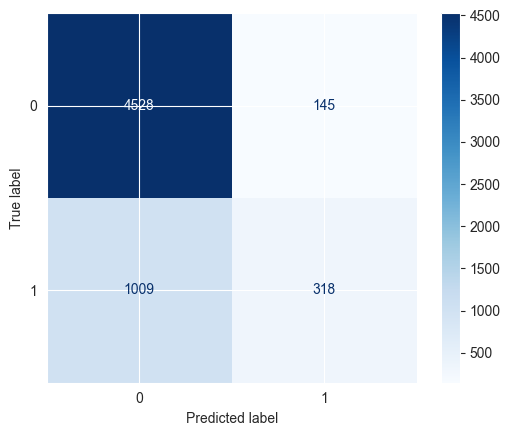

In [26]:
show_confusion_matrix(baseline, X_test, y_test)
# This is not good, we are having a lot of FN and the recall rate is really low, in fact FN is >> TP 1009/318

In [127]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, auc, PrecisionRecallDisplay, precision_recall_curve
def show_poc_auc(model, X_test, y_test):
    predictions = model[1].predict_proba(model[0].transform(X_test))
    y_score = predictions[:, 1]
    tpr, fpr, thresholds = roc_curve(y_test, y_score)
    roc_score = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_score)
    display.plot()
    plt.title('ROC_AUC')
    plt.show()
    # why roc_auc_score(y_test, y_score) gives 1-auc?

def show_pr_auc(model, X_test, y_test):
    predictions = model[1].predict_proba(model[0].transform(X_test))
    y_score = predictions[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    display = PrecisionRecallDisplay(recall=recall, precision=precision)
    display.plot()
    plt.title('PR_AUC')
    plt.show()

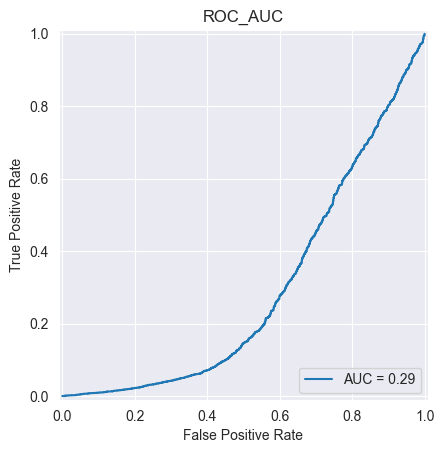

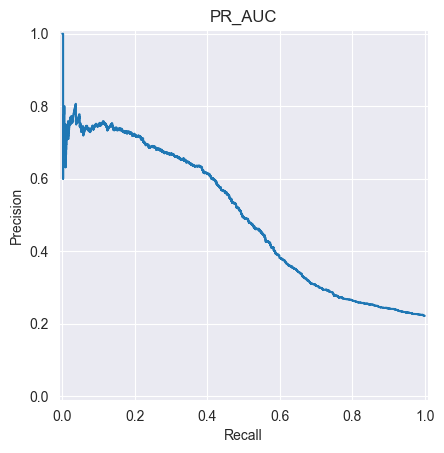

In [66]:
show_poc_auc(baseline, X_test, y_test)
show_pr_auc(baseline, X_test, y_test)

In [67]:
# We can see that the performance on positive class is pretty bad. From ROC_AUC, the value is even below 0.5, which means true positives can only get achieved at a high cost of false positives
# Same thing for PR curve as well, we need to really decrease the precision (somewhere -> 0.5) to only get a sensible amount of recall.

In [74]:
from sklearn.metrics import recall_score, f1_score, precision_score
def report_model(model, X_test, y_test):
    pred = model.predict(X_test)
    print(f"Precision score for {str(model[1])}: {precision_score(y_test, pred)}")
    print(f"Recall score for {str(model[1])}: {recall_score(y_test, pred)}")
    print(f"F1 score for {str(model[1])}: {f1_score(y_test, pred)}")

In [76]:
report_model(baseline, X_test, y_test)

report_model(baseline, X_train, y_train)

Precision score for LogisticRegression(): 0.6868250539956804
Recall score for LogisticRegression(): 0.23963828183873398
F1 score for LogisticRegression(): 0.3553072625698324
Precision score for LogisticRegression(): 0.7156063077759652
Recall score for LogisticRegression(): 0.24788095686569975
F1 score for LogisticRegression(): 0.36821488528259655


# Part 4 Compare L1, ElasticNet against L2
Hypothesis is that L1 might have similar performance with L2 on this? As there are not way too many feature compared to number of samples. Also, checking the performance on Training dataset, it shows that they are at similar performance, so the issue here is not overfitting, its actually the imbalance class make it tend toward high FN.

In [80]:
from sklearn.linear_model import LogisticRegressionCV
l1 = make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000))
l1.fit(X_train, y_train)
elas = make_pipeline(StandardScaler(), LogisticRegressionCV(penalty="elasticnet", solver="saga", l1_ratios=np.linspace(0, 1, 10), max_iter=2000))
elas.fit(X_train, y_train)

report_model(elas, X_test, y_test)
report_model(l1, X_test, y_test)
# Yea almost same performance

Precision score for LogisticRegressionCV(l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                     max_iter=2000, penalty='elasticnet', solver='saga'): 0.6883116883116883
Recall score for LogisticRegressionCV(l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                     max_iter=2000, penalty='elasticnet', solver='saga'): 0.23963828183873398
F1 score for LogisticRegressionCV(l1_ratios=array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                     max_iter=2000, penalty='elasticnet', solver='saga'): 0.3555058692006708
Precision score for LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear'): 0.6883116883116883
Recall score for LogisticRegression(max_iter=2000, penalty='l

# Part 5 Train on a balanced set

In [98]:
from sklearn.utils import resample
maj_train_X = X_train[y_train == 0]
maj_train_y = y_train[y_train == 0]
min_train_X = X_train[y_train == 1]
min_train_y = y_train[y_train == 1]

# Do under sampling here to avoid overfit
maj_train_X_rs, maj_train_y_rs = resample(maj_train_X, maj_train_y, replace=True, n_samples=len(min_train_X))
x_train_rs = pd.concat([maj_train_X_rs, min_train_X])
y_train_rs = pd.concat([maj_train_y_rs, min_train_y])

In [99]:
y_train_rs.value_counts() # now we got 5309 for each

default.payment.next.month
0    5309
1    5309
Name: count, dtype: int64

In [100]:
# Do the training again
l2 = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
l2.fit(x_train_rs, y_train_rs)
l2.score(X_test, y_test)

0.673

In [101]:
report_model(l2, X_test, y_test)

Precision score for LogisticRegression(): 0.3612931411096549
Recall score for LogisticRegression(): 0.6232102486812359
F1 score for LogisticRegression(): 0.45741150442477874


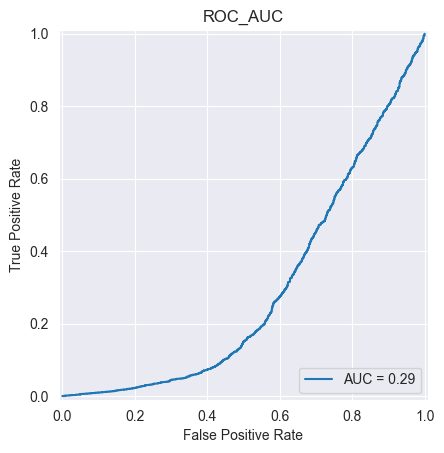

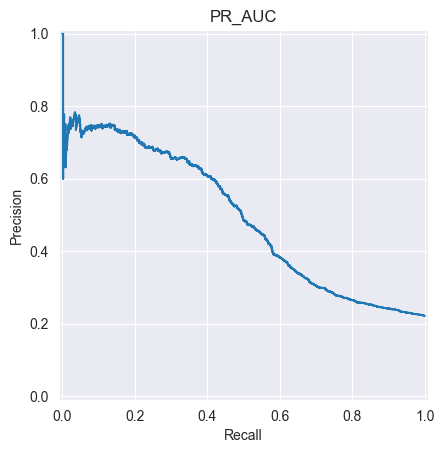

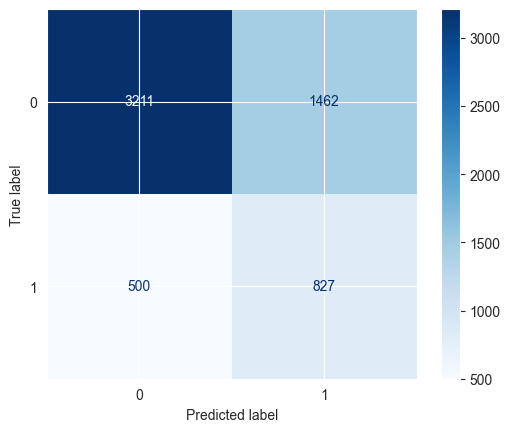

In [103]:
show_poc_auc(l2, X_test, y_test)
show_pr_auc(l2, X_test, y_test)
show_confusion_matrix(l2, X_test, y_test)
# AUC improved a little bit in this case, which is progress, this means that we are not that likely to miss default clients, but this is at the cost that more good client will get rejected

In [104]:
# Now lets try oversampling, to see if we can learn some extra information from negative class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
maj_train_X = X_train[y_train == 0]
maj_train_y = y_train[y_train == 0]
min_train_X = X_train[y_train == 1]
min_train_y = y_train[y_train == 1]

# Do under sampling here to avoid overfit
min_train_X_rs, min_train_y_rs = resample(min_train_X, min_train_y, replace=True, n_samples=len(maj_train_X))
x_train_rs = pd.concat([min_train_X_rs, maj_train_X])
y_train_rs = pd.concat([min_train_y_rs, maj_train_y])

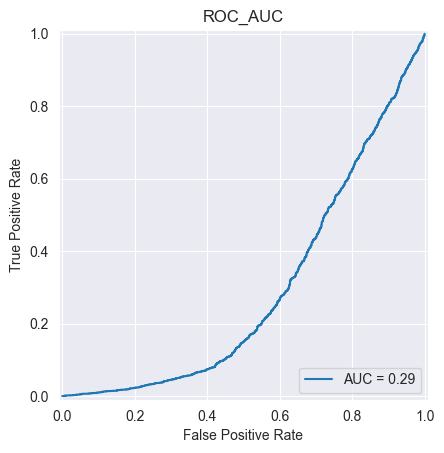

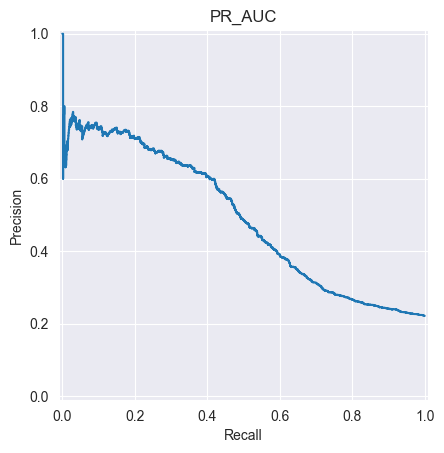

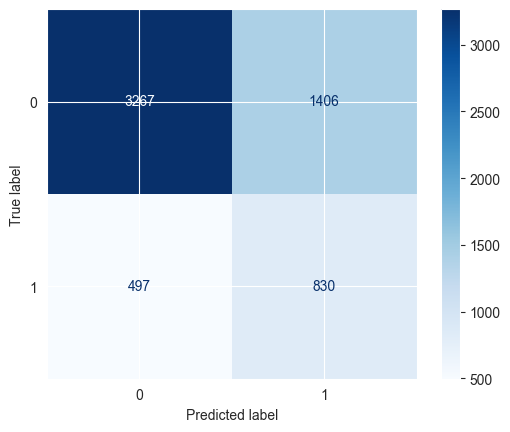

In [105]:
l2 = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)
l2.fit(x_train_rs, y_train_rs)
l2.score(X_test, y_test)
show_poc_auc(l2, X_test, y_test)
show_pr_auc(l2, X_test, y_test)
show_confusion_matrix(l2, X_test, y_test)

In [ ]:
# This is actually a bit better, FN (500 -> 497) FP (1462 -> 1460), which means we do learn some extra information on negative classes.

# Part 6 Try different weight
Now we examine the different weight's influence on logistic regression. As we want to increase the recall again, as missing 1 default will likely to cost more than miss classifying one negative. (miss classifying a default -> immediate money loss, miss classifying a negative -> still hurt but lose some confidence). One interesting thing to look at is as we change weight, at the cost of how may FP will we get TP.

For example, when we come from normal training -> oversample

FP, TP: (145, 318) -> (1406, 830): (1406-145)/(830-318) = 1261/512 = 2.46 When trying different model, we should always get this number, this will help to determine during the shift, what are the cost of FP to get TP gain. And in the bank we can have some number to evaluate the gain loss. To a balanced point.

In [109]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, baseline.predict(X_test), labels=baseline.classes_)
tn, fp, fn, tp = cm.ravel()

145 318


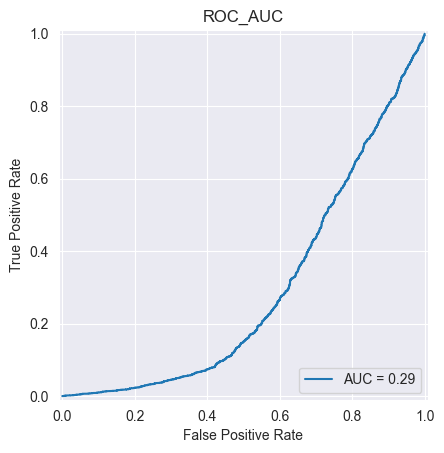

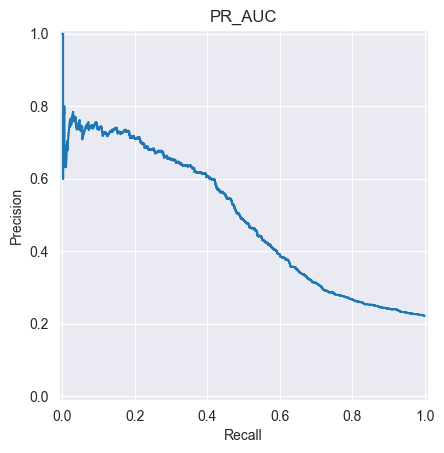

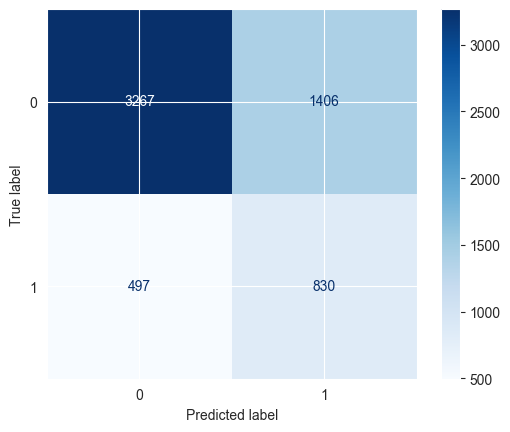

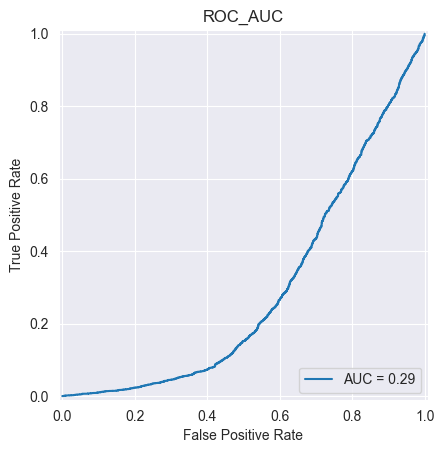

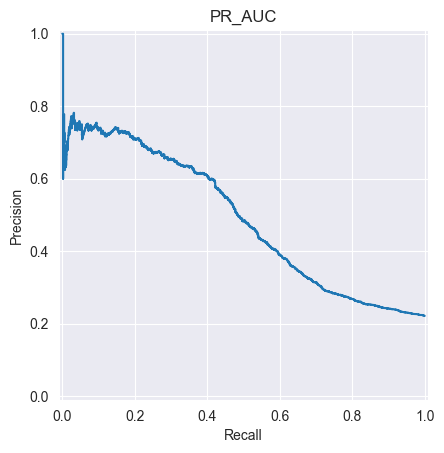

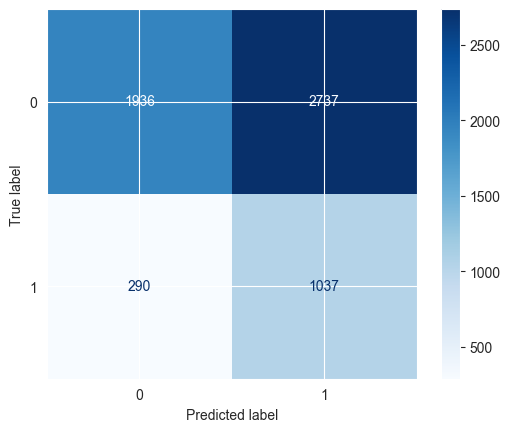

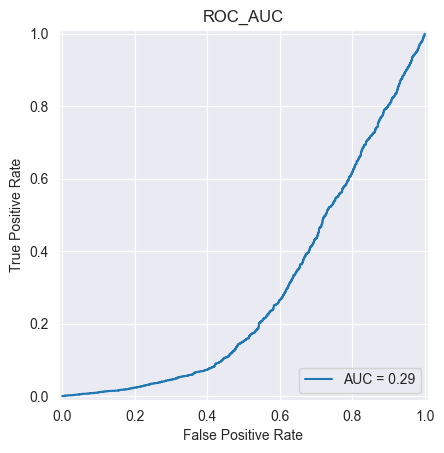

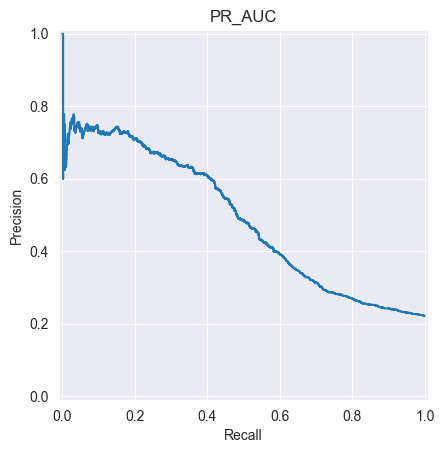

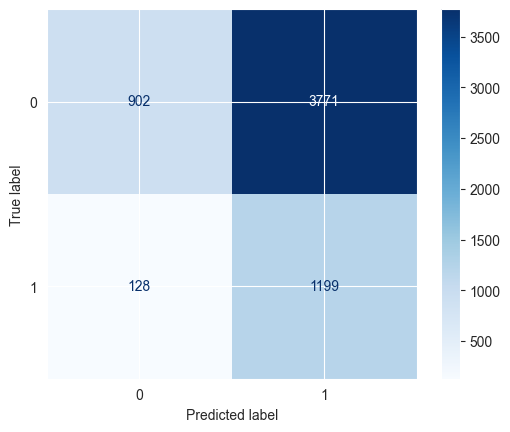

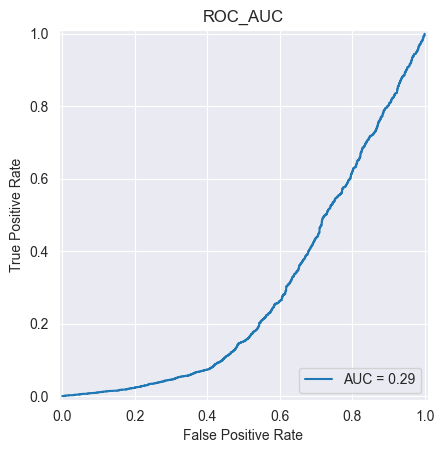

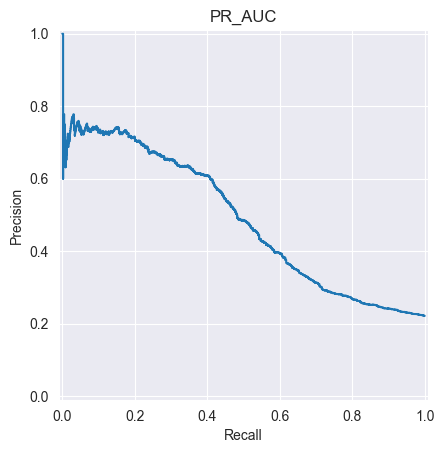

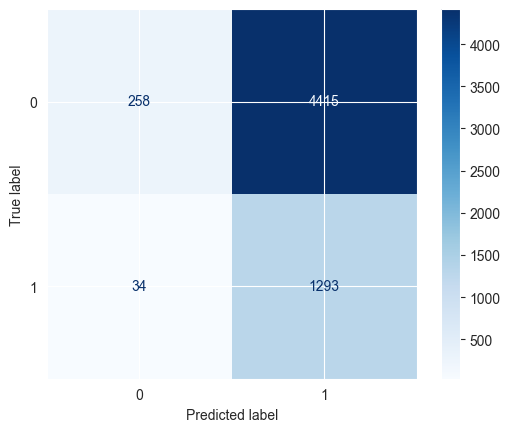

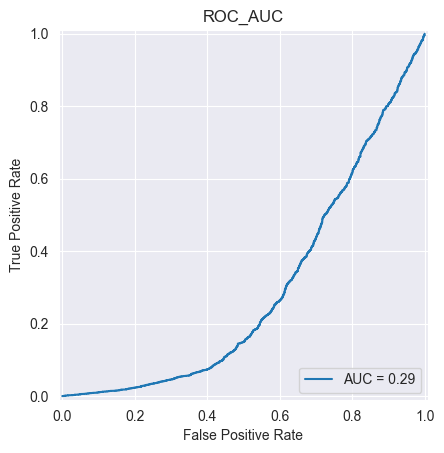

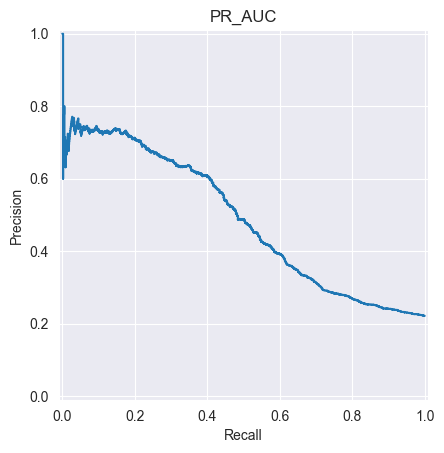

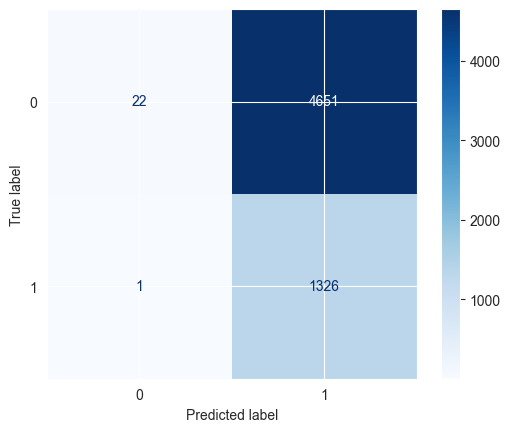

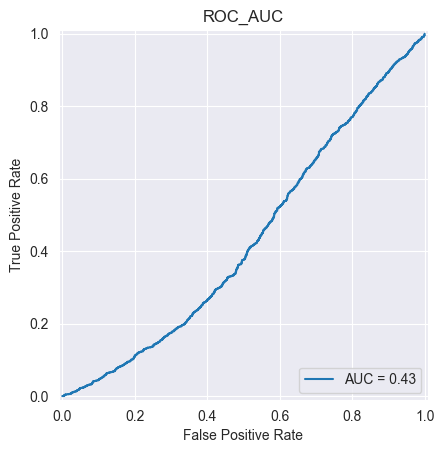

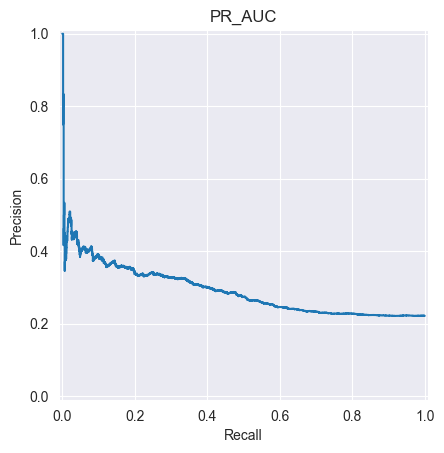

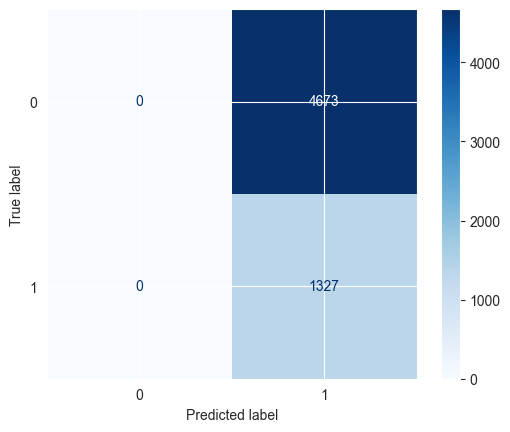

In [112]:
weights = np.linspace(0.5, 1, 6)
tns = []
tps = []
for weight in weights:
    w = make_pipeline(StandardScaler(), LogisticRegression(
        class_weight={1: weight, 0: 1-weight}
    ))
    w.fit(x_train_rs, y_train_rs)
    w.score(X_test, y_test)
    show_poc_auc(w, X_test, y_test)
    show_pr_auc(w, X_test, y_test)
    show_confusion_matrix(w, X_test, y_test)
    cm = confusion_matrix(y_test, w.predict(X_test), labels=w.classes_)
    tn_n, _, _, tp_n = cm.ravel()
    tns.append(tn_n)
    tps.append(tp_n)

In [ ]:
# humm a bit suspecious, auc always 0.29 under all settings? always same graph, did I do anything wrong?

At weight 0.5, with the cost of loss 1261 tns, we get 512 tps, at the rate of 2.462890625 tn/tp
At weight 0.6, with the cost of loss 2592 tns, we get 719 tps, at the rate of 3.6050069541029206 tn/tp
At weight 0.7, with the cost of loss 3626 tns, we get 881 tps, at the rate of 4.11577752553916 tn/tp
At weight 0.8, with the cost of loss 4270 tns, we get 975 tps, at the rate of 4.37948717948718 tn/tp
At weight 0.9, with the cost of loss 4506 tns, we get 1008 tps, at the rate of 4.470238095238095 tn/tp
At weight 1.0, with the cost of loss 4528 tns, we get 1009 tps, at the rate of 4.487611496531219 tn/tp


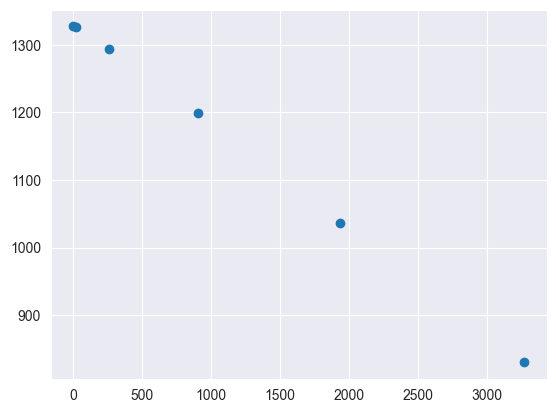

In [121]:
plt.scatter(tns, tps) # interesting that this is pretty linear
for i, weight in enumerate(weights):
    print(f"At weight {weight}, with the cost of loss {tn - tns[i]} tns, we get {tps[i] - tp} tps, at the rate of {(tn - tns[i])/(tps[i] - tp)} tn/tp")

# So based on this, we can get their relative estimated value to see where's the balance (i.e. if one default's loss is equal to 4 good client loss, then we should pretty much use 0.7 as a weight)

[0.        0.        0.        ... 0.9952921 0.9952921 1.       ]


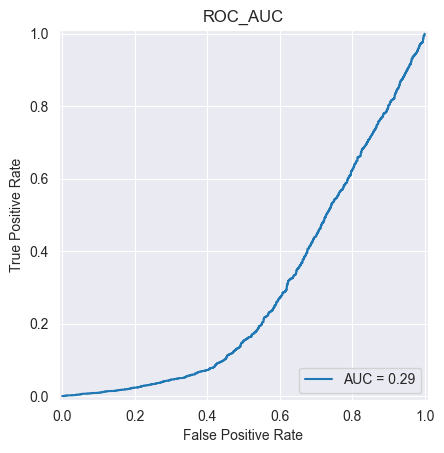

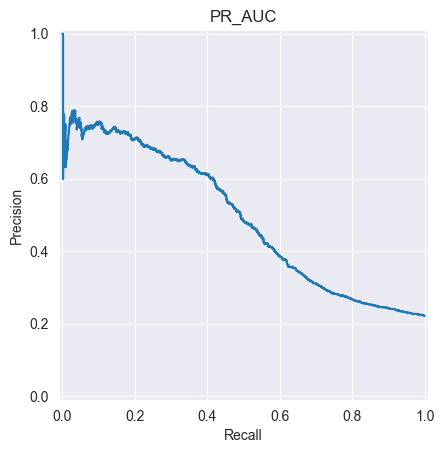

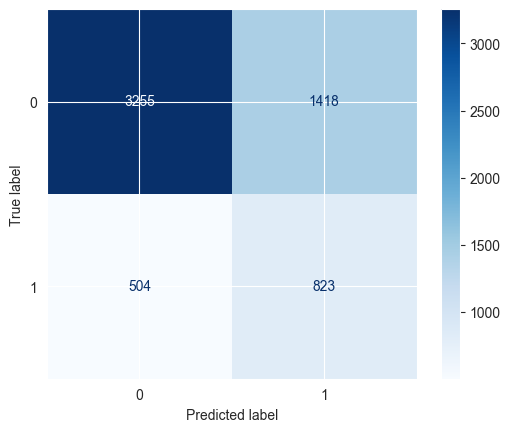

In [126]:
w = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
w.fit(X_train, y_train)
w.score(X_test, y_test)
show_poc_auc(w, X_test, y_test)
show_pr_auc(w, X_test, y_test)
show_confusion_matrix(w, X_test, y_test)
cm = confusion_matrix(y_test, w.predict(X_test), labels=w.classes_)
tn_n, _, _, tp_n = cm.ravel()
tns.append(tn_n)
tps.append(tp_n)

# GPT review

ROC code has args reversed
In your helper:

tpr, fpr, thresholds = roc_curve(y_test, y_score)
roc_score = auc(fpr, tpr)


roc_curve returns (fpr, tpr, thresholds). Because you swapped them, your AUC looks like ~“1 − true AUC” (you even left a comment about this 😄).

In [128]:
baseline.predict_proba(X_test) # this can do exactly the same

array([[0.89078504, 0.10921496],
       [0.88331461, 0.11668539],
       [0.77980226, 0.22019774],
       ...,
       [0.84370994, 0.15629006],
       [0.88105289, 0.11894711],
       [0.95710089, 0.04289911]])

Prefer PR-AUC alongside ROC-AUC

ROC-AUC is fine for ranking, but PR-AUC is more telling when positives are rare.

Track both while you iterate.

Business Justification:
For credit risk, the cost of missing a true defaulter (FN) is substantially higher than the cost of wrongly rejecting a good client (FP). By adjusting class weights and thresholds, we can trade some precision for higher recall. At τ=0.3, recall improves from 0.24 → 0.62, while precision drops from 0.68 → 0.36. This reduces false negatives by ~700, at the expense of ~1200 extra false positives. If one default costs the bank ~$10k in losses while rejecting a good client costs ~$2.5k in lost revenue, this threshold yields a net expected savings of ~$4.9M across the test population. We therefore recommend setting the operating threshold closer to 0.3 rather than the default 0.5.*